In [ ]:
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import matplotlib.pyplot as plt
from src.assoc_utils_np import *
from src.sensory_utils import *
from src.data_utils import *
from src.senstranspose_utils import *
from src.theory_utils import *
from src.assoc_utils_np_2D import gen_gbook_2d
from tqdm import tqdm as tqdm

lambdas = [3,4,5]                   # module period
M = len(lambdas)                             # num modules
Ng = np.sum(np.square(lambdas))                             # num grid cells
Npos = np.prod(lambdas)   
gbook = gen_gbook_2d(lambdas, Ng, Npos)
gbook = gbook.reshape(Ng, Npos*Npos)             # number of positions
Npos = Npos*Npos
Ns = Npos
Np=400
nruns=1

Wpg = randn(nruns, Np, Ng) #/ (np.sqrt(M));                      # fixed random gc-to-pc weights
c = 0.60     # connection probability
prune = int((1-c)*Np*Ng)
mask = np.ones((Np, Ng))
mask[randint(low=0, high=Np, size=prune), randint(low=0, high=Ng, size=prune)] = 0
Wpg = np.multiply(mask, Wpg)

thresh=0.5
pbook = nonlin(np.einsum('ijk,kl->ijl', Wpg, gbook), thresh)  # (nruns, Np, Npos)
Wgp = train_gcpc(pbook, gbook, Npos)

sbook = np.load('../../BW_miniimagenet_3600_60_60_full_rank.npy').reshape((3600,3600)).T  
sbook = sbook - np.mean(sbook.flatten())
indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
sbook = sbook[:,indices]

# c_miniimagenet = np.load("miniimagenet_3600_84_84_3.npy")
# sbook =c_miniimagenet.reshape((3600,84*84*3)).T
# c_images_avg = np.mean(sbook.flatten())
# sbook = sbook - c_images_avg
# indices = np.concatenate([np.arange(i, 3600, 600) for i in range(600)])
# sbook = sbook[:,indices]


Npatts=1000

#Below code for quantification of sequence results does not include scaffold sequence dynamics.
#Since VectorHASH factorizes the scaffold sequence dynamics from the memory retrieval dynamics, and we establish
#that sequence recall works, thus it suffices to run quantification on retrieval dynamics only to minimize runtime
sbookmin = np.amin(sbook); sbookmax = np.amax(sbook);
sbook_scaled = np.interp(sbook, (sbookmin, sbookmax), (-0.95, +0.95))
sbookinv = np.arctanh(sbook_scaled)
Wsp = pseudotrain_Wsp(sbookinv, pbook, Npatts)
Wps = pseudotrain_Wps(pbook, sbook, Npatts)
pin = nonlin(Wps@sbook[:,:Npatts], thresh=0)
gin = Wgp@pin
g = gridCAN_2d(gin,lambdas)
p = nonlin(Wpg@g, thresh)
sprenonlin=Wsp@p
sout_prescale = np.tanh(sprenonlin)
sout = np.interp(sout_prescale,(-0.95,+0.95),(sbookmin,sbookmax))

strue=sbook[:,:Npatts]
struenormed=(strue/np.linalg.norm(strue,axis=0));
soutnormed=(sout/np.linalg.norm(sout,axis=1));
dots = np.einsum('ijk,jk->ik',soutnormed,struenormed)


Wss = sbookinv[:,1:]@sbook[:,:-1].T
shops = np.zeros_like(sout)
shops[0,:,0]=sbook[:,0]
for i in tqdm(range(1,Npatts)):
    shops_prenonlin = Wss@shops[0,:,i-1]
    shops_prescale = np.tanh(shops_prenonlin)
    shops[0,:,i]=np.interp(shops_prescale,(-0.95,+0.95),(sbookmin,sbookmax))
    
shopsnormed=(shops/np.linalg.norm(shops,axis=1));
dotshops = np.einsum('ijk,jk->ik',shopsnormed,struenormed)
  
##Use below for BW minimagenet
for imgno in [3,7,23,30]:
    fi,ax=plt.subplots(1,3)
    ax[0].imshow(sbook[:,imgno].reshape((60,60)),cmap='gray');
    ax[0].set_axis_off()
    ax[0].set_title('true img'+str(imgno))
    ax[1].imshow(sout[0,:,imgno].reshape((60,60)),cmap='gray');
    ax[1].set_axis_off()
    ax[1].set_title('VH '+str(np.round(dots[0,imgno],2)));
    ax[2].imshow(shops[0,:,imgno].reshape((60,60)),cmap='gray');
    ax[2].set_axis_off()
    ax[2].set_title('Hf '+str(np.round(dotshops[0,imgno],2)));
    #plt.savefig('seq_recon_imgno'+str(imgno)+'.pdf')
    plt.show()

##Use below for minimagenet w color
# for imgno in [3,7,23,30]:
#     fi,ax=plt.subplots(1,3)
#     ax[0].imshow(sbook[:,imgno].reshape((84,84,3))+c_images_avg);
#     ax[0].set_axis_off()
#     ax[0].set_title('true img'+str(imgno))
#     ax[1].imshow(sout[0,:,imgno].reshape((84,84,3))+c_images_avg);
#     ax[1].set_axis_off()
#     ax[1].set_title('VH '+str(np.round(dots[0,imgno],2)));
#     ax[2].imshow(shops[0,:,imgno].reshape((84,84,3))+c_images_avg);
#     ax[2].set_axis_off()
#     ax[2].set_title('Hf '+str(np.round(dotshops[0,imgno],2)));
#     #plt.savefig('seq_recon_imgno'+str(imgno)+'.pdf')
#     plt.show()

In [1]:
###Baselines

import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from src.data_utils import read_pkl, write_pkl
from tqdm import tqdm as tqdm



def corrupt_p(codebook,p=0.1,booktype='-11'):
    rand_indices = np.sign(np.random.uniform(size=codebook.shape)- p )
    if booktype=='-11':
        return np.multiply(codebook,rand_indices)
    elif booktype=='01':
        return abs(codebook - 0.5*(-rand_indices+1))
    elif booktype=='cts':
        return codebook + np.random.normal(0,1,size=codebook.shape)*p
    else:
        print("codebook should be -11; 01; or cts")
        return 0

def get_weights_hetero(patts_in,patts_out,connectivity):
    if connectivity is 'standard':
        if learning == 'hebbian':
            W = patts_out @ patts_in.T
        elif learning == 'sparsehebbian':
            prob = sparsity #np.sum(patts)/patts.shape[0]/patts.shape[1]
            W =(1/patts_in.shape[0])* (patts_out - prob) @ (patts_in.T - prob)
        elif learning == 'pinv':
            W= patts_out @ np.linalg.pinv(patts_in)
        elif learning=='bounded_hebbian':
            num_patts = patts_in.shape[1]
            num_nodes = patts_in.shape[0]
            W = np.zeros((num_nodes,num_nodes))
            for i in range(num_patts):
                Wtmp = np.outer(patts_out[:,i] , patts_in[:,i])/np.sqrt(num_nodes)
                # ~ print(np.amax(Wtmp))
                W = cap(Wtmp + W,bound)
        # W = W - np.diag(np.diag(W))
    else:
        N = connectivity.shape[0]
        W = sparse.lil_matrix(connectivity.shape)
        for i in range(N):
            for j in connectivity.rows[i]:
                W[i,j] = np.dot(patts_out[i],patts_in[j])
        # W.setdiag(0)
    return W


def cap(W,bound):
    W1=np.where(W>bound,bound*np.ones(W.shape),W)
    W2=np.where(W1<-bound,-bound*np.ones(W.shape),W1)
    return W2

def get_weights(patterns,connectivity):
    if connectivity == 'standard':
        if learning == 'hebbian':
            W = patts @ patts.T
        elif learning == 'sparsehebbian':
            prob = sparsity #np.sum(patts)/patts.shape[0]/patts.shape[1]
            W =(1/patts.shape[0])* (patts - prob) @ (patts.T - prob)
        elif learning == 'pinv':
            W= patts @ np.linalg.pinv(patts)
        elif learning is 'bounded_hebbian':
            num_patts = patts.shape[1]
            num_nodes = patts.shape[0]
            W = np.zeros((num_nodes,num_nodes))
            for i in range(num_patts):
                Wtmp = np.outer(patts[:,i] , patts[:,i])/np.sqrt(num_nodes)
                # ~ print(np.amax(Wtmp))
                W = cap(Wtmp + W,bound)
        W = W - np.diag(np.diag(W))
    else:
        N = connectivity.shape[0]
        W = sparse.lil_matrix(connectivity.shape)
        for i in range(N):
            for j in connectivity.rows[i]:
                W[i,j] = np.dot(patterns[i],patterns[j])
        W.setdiag(0)
    return W


def entropy(inlist):
    ent = np.zeros(len(inlist))
    for idx,x in enumerate(inlist):
        if x == 0 or x == 1:
            ent[idx] = 0
        else:
            ent[idx] = -1 * ( x*np.log2(x) + (1-x)*np.log2(1-x) )
    return ent

<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\chand\AppData\Local\Temp\ipykernel_19308\4279035768.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if connectivity is 'standard':
C:\Users\chand\AppData\Local\Temp\ipykernel_19308\4279035768.py:63: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif learning is 'bounded_hebbian':


In [7]:
nruns=5

100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [00:02<00:00, 28.66it/s]


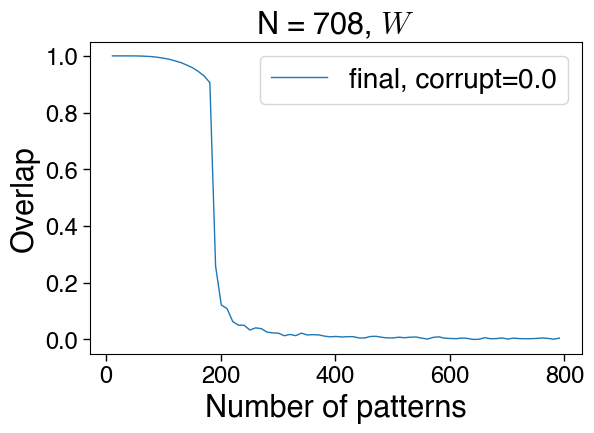

C:\Users\chand\AppData\Local\Temp\ipykernel_19308\3107736024.py:84: RuntimeWarning: divide by zero encountered in log2
  S = - a * np.log2(a) - b * np.log2(b)
C:\Users\chand\AppData\Local\Temp\ipykernel_19308\3107736024.py:84: RuntimeWarning: invalid value encountered in multiply
  S = - a * np.log2(a) - b * np.log2(b)


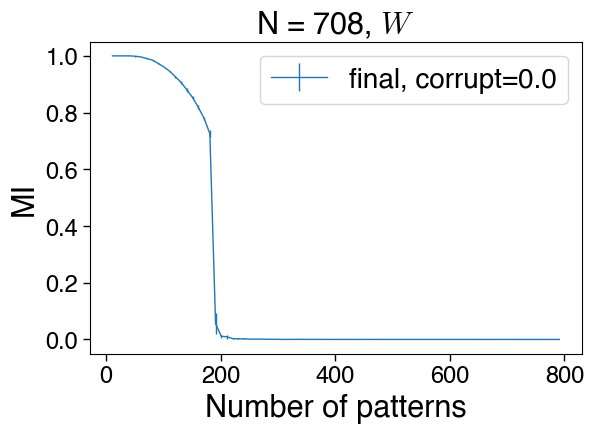

In [ ]:
N = 708
corrupt_fraction = 0.0
Npatts_list = np.arange(1,800,10)
connectivity='standard' # Standard fully connected Hopfield network. For sparse connectivity use the next cell
# learning can be 'hebbian', 'bounded_hebbian', 'pinv', or 'sparsehebbian' for sparse hopfield network
learning='hebbian'
# bound=0.3  #Use bound param if learning='bounded_hebbian'


init_overlap = np.zeros((nruns,*Npatts_list.shape))
final_overlap = np.zeros((nruns,*Npatts_list.shape))
MI_hc = np.zeros((nruns,*Npatts_list.shape))

for runidx in range(nruns):
    if learning=='sparsehebbian':
        # sparse hopfiled 0/1 code
        sparsity = 0.2
        patterns = 1*(np.random.rand(N,Npatts_list.max()) > (1-sparsity))
        corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='01')
    else:
        patterns = np.sign(np.random.normal(0,1,(N,Npatts_list.max())))
        corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='-11')
        
    for idx,Npatts in enumerate(tqdm(Npatts_list)):
        #print(Npatts)
        patts = patterns[:,:Npatts]
        cor_patts = corrupt_patts[:,:Npatts]
        W = get_weights_hetero(patts[:,:-1],patts[:,1:],connectivity)
        out_patts = np.zeros(patts.shape)
        out_patts[:,0] = corrupt_patts[:,0]
        
        # sparse hopfield
        # theta = np.sum(W-np.diag(W), axis=1)
        theta=0.05 #0.04 #0
        
        
        for ite in range(1,Npatts):
            if learning=='sparsehebbian':
                out_patts[:,ite] = (np.sign(W@out_patts[:,ite-1] - theta)+1)/2
            else:
                out_patts[:,ite] = np.sign(W@out_patts[:,ite-1])
   
        
        
        #err = np.average(np.einsum('ij,ij->j',rep,patts)/N)
        err = np.einsum('ij,ij->j',out_patts[:,1:],patts[:,1:])/N
        overlap = np.average(err) 
        final_overlap[runidx,idx] = overlap #err
        
        if learning=='sparsehebbian':
            q = np.sum(np.abs(out_patts[:,1:]), axis=0) / N  # sparse hopfield
            m = err
            p = np.sum(patts[:,1:], axis=0)/patts.shape[0]
            P1e = 1 - (m/p)
            P0e = (q-m)/(1-p)
            MI_hc[runidx,idx] =  np.average( entropy(q) - ( p*entropy(P1e) + (1-p)*entropy(P0e) ) )


# print(init_overlap)
# print(final_overlap)

results_dir = "continuum_results_seq"
filename = f"stdhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_nruns={nruns}"
# filename = f"pinvhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_nruns={nruns}"
# filename = f"sparsehopfield__mutualinfo_N={N}_noise={corrupt_fraction}_p={sparsity}_nruns={nruns}"
# filename = f"boundedhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_bound={bound}_nruns={nruns}"

fig1 = plt.figure(1)
# plt.plot(Npatts_list,init_overlap, label='single, corrupt='+str(corrupt_fraction));
plt.plot(Npatts_list,final_overlap.mean(axis=0), label='final, corrupt='+str(corrupt_fraction));
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("Overlap");
plt.title(r"N = "+str(N)+", $W$");
plt.show()

if learning=='sparsehebbian':
    print("MI already calculated in loop")
else:
    m = final_overlap
    a = (1+m)/2
    b = (1-m)/2

    S = - a * np.log2(a) - b * np.log2(b)
    S = np.where(m==1, np.zeros_like(S), S)

    MI_hc = 1 - S


fig2 = plt.figure(1)
plt.errorbar(Npatts_list,MI_hc.mean(axis=0),yerr=MI_hc.std(axis=0), label='final, corrupt='+str(corrupt_fraction)); #plt.xscale('log'); plt.yscale('log');
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("MI");
plt.title(r"N = "+str(N)+", $W$");
plt.show()


  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\chand\anaconda3\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\chand\anaconda3\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:50<00:00,  2.52s/it]


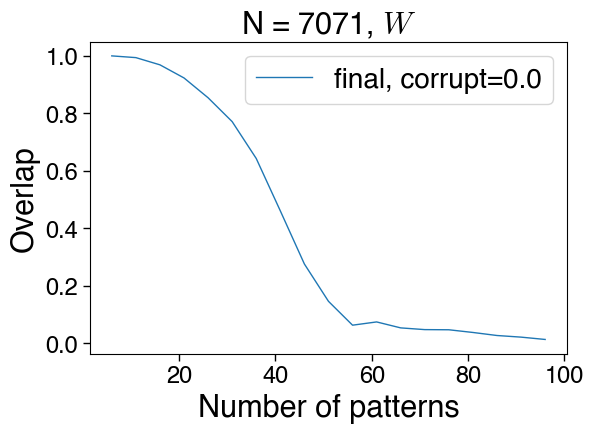

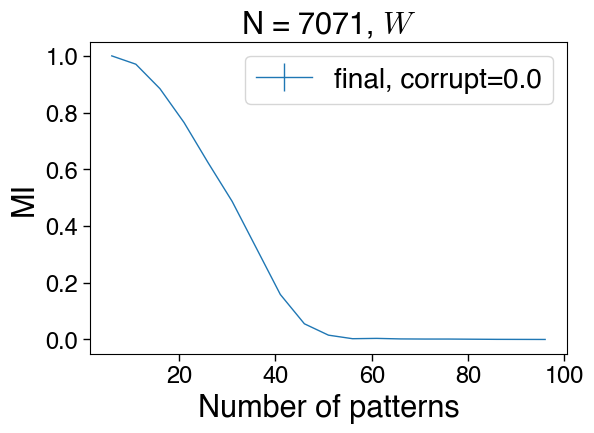

In [3]:
#Hopfield with sparse connectivity (For other variants of Hopfield model use above cell)

N = 7071
gamma = 1e-2
corrupt_fraction = 0.0
Npatts_list = np.arange(1,100,5)


connectivity = sparse.lil_matrix((N,N))
for i in range(N):
    connectivity[i,np.random.randint(0,N,int(gamma*N))] = 1

    
init_overlap = np.zeros((nruns,*Npatts_list.shape))
final_overlap = np.zeros((nruns,*Npatts_list.shape))
MI_hc = np.zeros((nruns,*Npatts_list.shape))

for runidx in range(nruns):
    patterns = np.sign(np.random.normal(0,1,(N,Npatts_list.max())))
    corrupt_patts = corrupt_p(patterns,p=corrupt_fraction,booktype='-11')
    for idx,Npatts in enumerate(tqdm(Npatts_list)):
        #print(Npatts)
        patts = patterns[:,:Npatts]
        cor_patts = corrupt_patts[:,:Npatts]
        W = get_weights_hetero(patts[:,:-1],patts[:,1:],connectivity)
        out_patts = np.zeros(patts.shape)
        out_patts[:,0] = corrupt_patts[:,0]
                
        
        for ite in range(1,Npatts):
            out_patts[:,ite] = np.sign(W@out_patts[:,ite-1])
            # out_patts[:,ite] = (np.sign(W@out_patts[:,ite-1] - theta)+1)/2
        
        
        
        err = np.einsum('ij,ij->j',out_patts[:,1:],patts[:,1:])/N
        overlap = np.average(err) 
        final_overlap[runidx,idx] = overlap #err
        



results_dir = "continuum_results_seq"
filename = f"sparseconnhopfield__mutualinfo_N={N}_noise={corrupt_fraction}_gamma={gamma}_nruns={nruns}"

fig1 = plt.figure(1)
plt.plot(Npatts_list,final_overlap.mean(axis=0), label='final, corrupt='+str(corrupt_fraction));
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("Overlap");
plt.title(r"N = "+str(N)+", $W$");
plt.show()


m = final_overlap
a = (1+m)/2
b = (1-m)/2

S = - a * np.log2(a) - b * np.log2(b)
S = np.where(m==1, np.zeros_like(S), S)

MI_hc = 1 - S


fig2 = plt.figure(1)
plt.errorbar(Npatts_list,MI_hc.mean(axis=0),yerr=MI_hc.std(axis=0), label='final, corrupt='+str(corrupt_fraction)); #plt.xscale('log'); plt.yscale('log');
plt.legend()
plt.xlabel('Number of patterns')
plt.ylabel("MI");
plt.title(r"N = "+str(N)+", $W$");
plt.show()
